# 1.22a: Radial vs Tangential Motion

**Goal:** Decompose dead token motion into radial (toward/away from origin) and tangential (perpendicular) components.

## The Question

Dead tokens move during training, but **how** do they move?

- **Radial motion:** Moving toward or away from the origin (changing r)
- **Tangential motion:** Moving around a spherical shell (changing angles, constant r)

**Hypothesis:** Most dead token motion is **tangential** (moving around the shell) rather than radial (in/out).

## Vector Decomposition

For token at position $\mathbf{w}(t)$:

**Radial direction:**
$$\hat{r}(t) = \frac{\mathbf{w}(t)}{\|\mathbf{w}(t)\|}$$

**Displacement:**
$$\Delta \mathbf{w}(t) = \mathbf{w}(t+1) - \mathbf{w}(t)$$

**Radial component (signed):**
$$\Delta r(t) = \Delta \mathbf{w}(t) \cdot \hat{r}(t)$$

- $\Delta r > 0$: moving outward
- $\Delta r < 0$: moving inward

**Signed radial fraction:**
$$f_{\text{radial}}(t) = \frac{\Delta r(t)}{\|\Delta \mathbf{w}(t)\|}$$

This ranges from -1 (purely inward) to +1 (purely outward), with 0 indicating purely tangential motion.

## Parameters

In [1]:
# Data paths
FLANNEL_1_PATH = '../tensors/Flannel/1.20a_flannel_1.safetensors'
TOKEN_MASKS_PATH = '../tensors/Flannel/live_dead_tokens.safetensors'

# Analysis parameters
SMOOTHING_WINDOW = 50  # For running average of mean

# Visualization
PLOT_DPI = 150
ALPHA_TOKENS = 0.02  # Low alpha for individual token traces
COLOR_TOKENS = 'steelblue'
COLOR_MEAN = 'crimson'
COLOR_SMOOTH = 'black'
LINEWIDTH_MEAN = 2
LINEWIDTH_SMOOTH = 3

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading data...\n")

# Flannel 1
data_1 = load_file(FLANNEL_1_PATH)
W_1 = data_1['embeddings'].to(torch.float32).to(device)

# Token masks
masks = load_file(TOKEN_MASKS_PATH)
dead_mask = masks['dead_mask'].to(device)

n_steps, vocab_size, hidden_dim = W_1.shape
n_dead = dead_mask.sum().item()

print(f"✓ Data loaded")
print(f"  Shape: {W_1.shape}")
print(f"  Dead tokens: {n_dead}")
print(f"  Device: {device}")

Loading data...

✓ Data loaded
  Shape: torch.Size([1001, 10000, 64])
  Dead tokens: 3699
  Device: mps


## Extract Dead Token Embeddings

In [5]:
# Extract dead tokens only
W_dead = W_1[:, dead_mask, :]  # (n_steps, n_dead, hidden_dim)

print(f"\nDead token embeddings:")
print(f"  Shape: {W_dead.shape}")


Dead token embeddings:
  Shape: torch.Size([1001, 3699, 64])


## Compute Radial Decomposition

For each token at each timestep:
1. Compute displacement vector Δw = w(t+1) - w(t)
2. Compute radial direction r̂ = w(t) / ||w(t)||
3. Compute radial component: Δr = Δw · r̂
4. Compute signed radial fraction: f = Δr / ||Δw||

In [6]:
print("\nComputing radial decomposition...\n")

# Preallocate
radial_fraction = torch.zeros(n_steps - 1, n_dead, device=device)

for t in range(n_steps - 1):
    # Current positions
    w_t = W_dead[t]  # (n_dead, hidden_dim)
    w_t1 = W_dead[t + 1]
    
    # Displacement vectors
    delta_w = w_t1 - w_t  # (n_dead, hidden_dim)
    
    # Radial directions (unit vectors pointing from origin to token)
    norms = torch.norm(w_t, p=2, dim=1, keepdim=True)  # (n_dead, 1)
    r_hat = w_t / (norms + 1e-10)  # (n_dead, hidden_dim), avoid div by zero
    
    # Radial component (signed): Δr = Δw · r̂
    delta_r = (delta_w * r_hat).sum(dim=1)  # (n_dead,)
    
    # Displacement magnitude
    delta_w_norm = torch.norm(delta_w, p=2, dim=1)  # (n_dead,)
    
    # Signed radial fraction: f = Δr / ||Δw||
    # Ranges from -1 (purely inward) to +1 (purely outward)
    radial_fraction[t] = delta_r / (delta_w_norm + 1e-10)

print(f"✓ Computed radial decomposition")
print(f"  Shape: {radial_fraction.shape}")
print(f"  Range: [{radial_fraction.min().item():.6f}, {radial_fraction.max().item():.6f}]")


Computing radial decomposition...

✓ Computed radial decomposition
  Shape: torch.Size([1000, 3699])
  Range: [-0.490175, 0.965720]


## Bulk Statistics

In [7]:
print("\n" + "="*80)
print("RADIAL MOTION STATISTICS")
print("="*80 + "\n")

radial_fraction_cpu = radial_fraction.cpu().numpy()

# Flatten to get all displacement vectors across all tokens and timesteps
all_fractions = radial_fraction_cpu.flatten()

print(f"Total displacement vectors: {len(all_fractions):,}")
print(f"  (= {n_dead} dead tokens × {n_steps-1} timesteps)")
print()

print(f"Signed radial fraction:")
print(f"  Mean: {all_fractions.mean():.6f}")
print(f"  Std: {all_fractions.std():.6f}")
print(f"  Median: {np.median(all_fractions):.6f}")
print(f"  Range: [{all_fractions.min():.6f}, {all_fractions.max():.6f}]")
print()

print(f"Percentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(all_fractions, p)
    print(f"  {p:2d}%: {val:+.6f}")
print()

# Absolute radial fraction (ignore sign, just measure how radial vs tangential)
abs_fractions = np.abs(all_fractions)
mean_abs_fraction = abs_fractions.mean()

print(f"Absolute radial fraction (ignoring direction):")
print(f"  Mean: {mean_abs_fraction:.6f}")
print(f"  → {mean_abs_fraction*100:.2f}% radial, {(1-mean_abs_fraction)*100:.2f}% tangential")
print()

# Interpretation
print(f"Interpretation:")
if abs(all_fractions.mean()) < 0.1:
    print(f"  → Mean near zero: no systematic expansion or contraction")
elif all_fractions.mean() > 0.1:
    print(f"  → Positive mean: net expansion (tokens moving outward)")
else:
    print(f"  → Negative mean: net contraction (tokens moving inward)")

if mean_abs_fraction < 0.3:
    print(f"  → Low absolute fraction: motion is mostly TANGENTIAL")
    print(f"  → Tokens moving around the shell, not in/out")
elif mean_abs_fraction < 0.6:
    print(f"  → Moderate absolute fraction: mix of radial and tangential")
else:
    print(f"  → High absolute fraction: motion is mostly RADIAL")
    print(f"  → Tokens moving in/out, not around")

print("\n" + "="*80)


RADIAL MOTION STATISTICS

Total displacement vectors: 3,699,000
  (= 3699 dead tokens × 1000 timesteps)

Signed radial fraction:
  Mean: 0.139663
  Std: 0.250673
  Median: 0.000000
  Range: [-0.490175, 0.965720]

Percentiles:
   1%: +0.000000
   5%: +0.000000
  10%: +0.000000
  25%: +0.000000
  50%: +0.000000
  75%: +0.192681
  90%: +0.549816
  95%: +0.786549
  99%: +0.891950

Absolute radial fraction (ignoring direction):
  Mean: 0.140194
  → 14.02% radial, 85.98% tangential

Interpretation:
  → Positive mean: net expansion (tokens moving outward)
  → Low absolute fraction: motion is mostly TANGENTIAL
  → Tokens moving around the shell, not in/out



## Distribution of Radial Fractions


Plotting distribution of radial fractions...



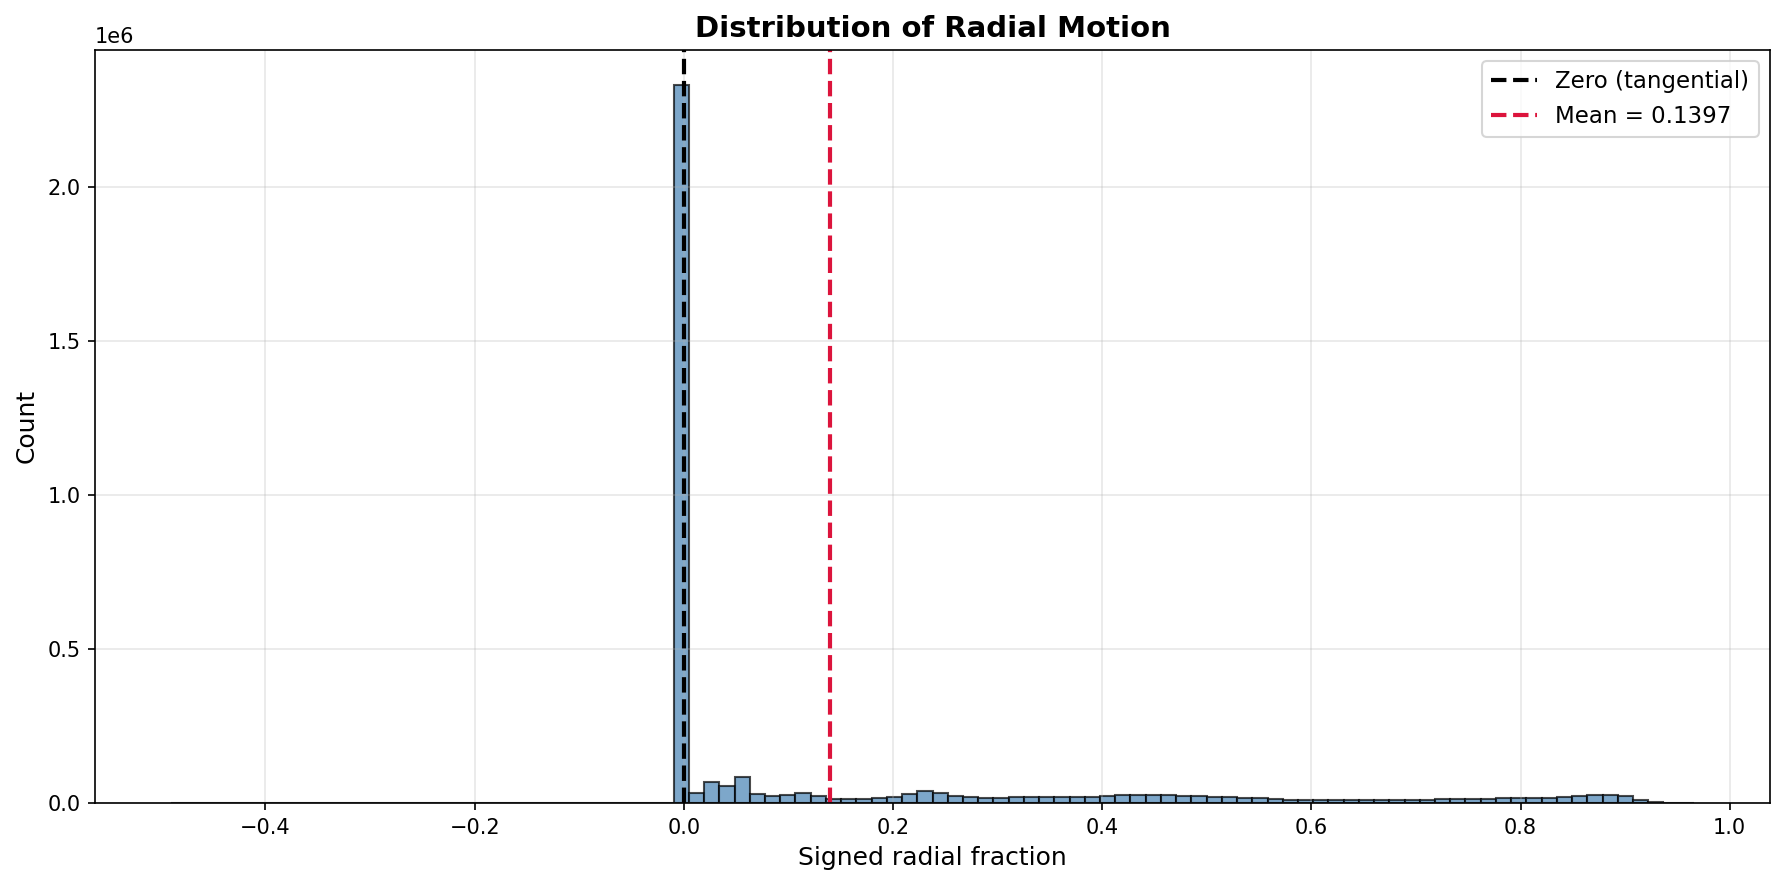

✓ Distribution plot complete


In [8]:
print("\nPlotting distribution of radial fractions...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=PLOT_DPI)

ax.hist(all_fractions, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero (tangential)')
ax.axvline(all_fractions.mean(), color='crimson', linestyle='--', linewidth=2,
           label=f'Mean = {all_fractions.mean():.4f}')

ax.set_xlabel('Signed radial fraction', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Radial Motion', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Distribution plot complete")

## Main Plot: Signed Radial Fraction Over Time

**Layers:**
1. Individual tokens (low alpha blue)
2. Mean across tokens (red)
3. Smoothed mean (running average, black)

In [9]:
print("\nComputing mean and smoothed mean...\n")

# Mean across tokens at each timestep
mean_radial = radial_fraction.mean(dim=1).cpu().numpy()  # (n_steps-1,)

# Smoothed mean (running average)
def running_average(x, window):
    """Compute running average with given window size."""
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / window

smoothed_mean = running_average(mean_radial, SMOOTHING_WINDOW)
# Adjust timesteps to match smoothed_mean length
smoothed_timesteps = np.arange(len(smoothed_mean))

print(f"✓ Computed statistics")
print(f"  Mean shape: {mean_radial.shape}")
print(f"  Smoothed shape: {smoothed_mean.shape}")
print(f"  Smoothed timesteps: {smoothed_timesteps.shape}")


Computing mean and smoothed mean...

✓ Computed statistics
  Mean shape: (1000,)
  Smoothed shape: (951,)
  Smoothed timesteps: (951,)



Plotting signed radial fraction over time...

  Plotting 3699 individual token traces...
  Plotting mean...
  Plotting smoothed mean (window=50)...


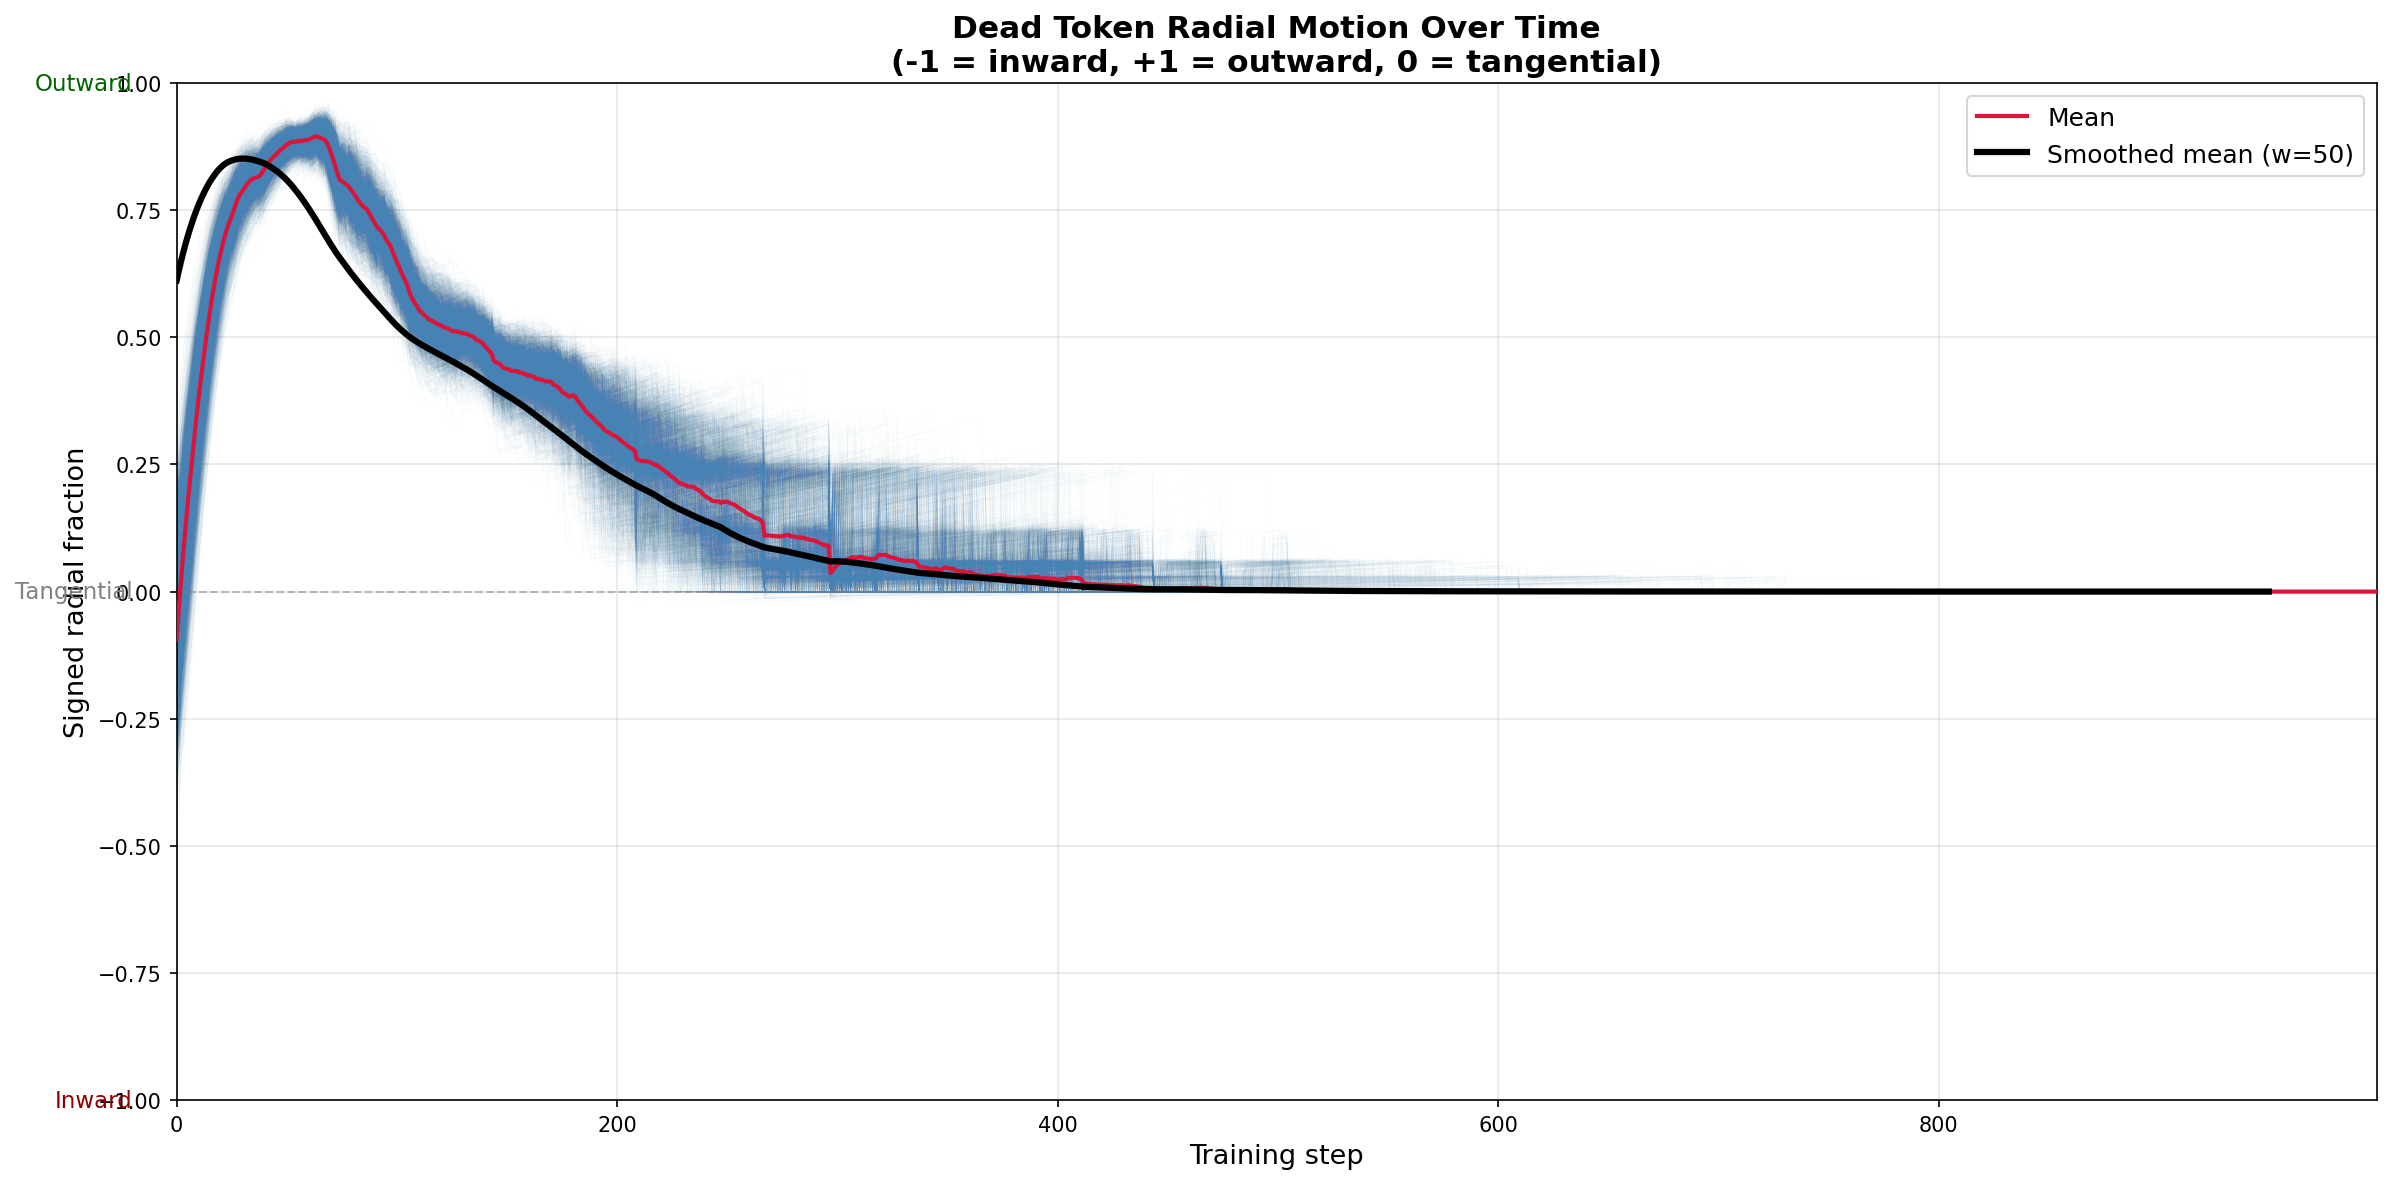


✓ Radial fraction plot complete


In [10]:
print("\nPlotting signed radial fraction over time...\n")

fig, ax = plt.subplots(figsize=(16, 8), dpi=PLOT_DPI)

timesteps = np.arange(n_steps - 1)

# Layer 1: Individual tokens (low alpha blue)
print(f"  Plotting {n_dead} individual token traces...")
for i in range(n_dead):
    ax.plot(timesteps, radial_fraction_cpu[:, i], 
            color=COLOR_TOKENS, alpha=ALPHA_TOKENS, linewidth=0.5)

# Layer 2: Mean (red)
print(f"  Plotting mean...")
ax.plot(timesteps, mean_radial, 
        color=COLOR_MEAN, linewidth=LINEWIDTH_MEAN, label='Mean', zorder=10)

# Layer 3: Smoothed mean (black)
print(f"  Plotting smoothed mean (window={SMOOTHING_WINDOW})...")
ax.plot(smoothed_timesteps, smoothed_mean, 
        color=COLOR_SMOOTH, linewidth=LINEWIDTH_SMOOTH, 
        label=f'Smoothed mean (w={SMOOTHING_WINDOW})', zorder=11)

# Zero line
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=5)

ax.set_xlabel('Training step', fontsize=13)
ax.set_ylabel('Signed radial fraction', fontsize=13)
ax.set_title('Dead Token Radial Motion Over Time\n(-1 = inward, +1 = outward, 0 = tangential)', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='best')
ax.set_xlim(0, n_steps-2)
ax.set_ylim(-1, 1)

# Y-axis labels
ax.text(-0.02, 1, 'Outward', transform=ax.get_yaxis_transform(), 
        fontsize=11, ha='right', va='center', color='darkgreen')
ax.text(-0.02, -1, 'Inward', transform=ax.get_yaxis_transform(), 
        fontsize=11, ha='right', va='center', color='darkred')
ax.text(-0.02, 0, 'Tangential', transform=ax.get_yaxis_transform(), 
        fontsize=11, ha='right', va='center', color='gray')

plt.tight_layout()
plt.show()

print("\n✓ Radial fraction plot complete")

## Summary

In [11]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80 + "\n")

print(f"Dead tokens: {n_dead}")
print(f"Timesteps: {n_steps-1} (displacement vectors)")
print()

print(f"Radial motion characterization:")
print(f"  Mean signed fraction: {all_fractions.mean():.6f}")
print(f"  Mean absolute fraction: {mean_abs_fraction:.6f}")
print()

# Radial vs tangential breakdown
print(f"Motion composition:")
print(f"  Radial component: {mean_abs_fraction*100:.1f}%")
print(f"  Tangential component: {(1-mean_abs_fraction)*100:.1f}%")
print()

# Direction
if abs(all_fractions.mean()) < 0.05:
    print(f"Direction: BALANCED (no net expansion or contraction)")
elif all_fractions.mean() > 0:
    print(f"Direction: EXPANDING (net outward motion)")
else:
    print(f"Direction: CONTRACTING (net inward motion)")
print()

# Character of motion
if mean_abs_fraction < 0.3:
    print(f"Character: Predominantly TANGENTIAL motion")
    print(f"  → Tokens moving around spherical shells")
    print(f"  → Little radial expansion or contraction")
    print(f"  → Cloud maintains roughly constant radius")
elif mean_abs_fraction < 0.6:
    print(f"Character: MIXED radial and tangential motion")
    print(f"  → Tokens both moving in/out and around")
else:
    print(f"Character: Predominantly RADIAL motion")
    print(f"  → Tokens moving strongly in/out from origin")
    print(f"  → Cloud radius changing significantly")

print("\n" + "="*80)


SUMMARY

Dead tokens: 3699
Timesteps: 1000 (displacement vectors)

Radial motion characterization:
  Mean signed fraction: 0.139663
  Mean absolute fraction: 0.140194

Motion composition:
  Radial component: 14.0%
  Tangential component: 86.0%

Direction: EXPANDING (net outward motion)

Character: Predominantly TANGENTIAL motion
  → Tokens moving around spherical shells
  → Little radial expansion or contraction
  → Cloud maintains roughly constant radius

